In [62]:
import numpy as np
import matplotlib.pyplot as plt
import winsound
from scipy import ndimage
import pickle


FOLDERPATH = 'default'
SAVEPATH = 'average/'

SAMPLES = 13
STEP_SIZE = 20
STEP_Q = 1920
STEP_LAST = 1919

N1_STOCHASTIC = 0
N2_STOCHASTIC = 1
N3_STOCHASTIC = 2
N1_COARSE = 3
N2_COARSE = 4
N3_COARSE = 5
N1_DIFFUSION = 6
N2_DIFFUSION = 7
N3_DIFFUSION = 8
N1_VARRED = 9 
N2_VARRED = 10
N3_VARRED = 11
O2_DATA = 12
VEGF_DATA = 13

ly = 50
lx = 50
spatial_delta = 0.004
dt = 300
D2 = 0.000005

n1_coarse = np.zeros((SAMPLES, STEP_Q, lx, ly))
n2_coarse = np.zeros((SAMPLES, STEP_Q, lx, ly))
n1_stochastic = np.zeros((SAMPLES, STEP_Q, lx, ly))
n2_stochastic = np.zeros((SAMPLES, STEP_Q, lx, ly))
n1_diffusion = np.zeros((SAMPLES, STEP_Q, lx, ly))
n2_diffusion = np.zeros((SAMPLES, STEP_Q, lx, ly))
n2_varred = np.zeros((SAMPLES, STEP_Q, lx, ly))

for i in range(SAMPLES):
    filehandler = open(FOLDERPATH + str(i) + '/' +'density_data.obj', 'rb') 
    density_data = pickle.load(filehandler)
    n1_coarse[i, :, :, :] = density_data[N1_COARSE, :, :, :]
    n2_coarse[i, :, :, :] = density_data[N2_COARSE, :, :, :]
    n1_stochastic[i, :, :, :] = density_data[N1_STOCHASTIC, :, :, :]
    n2_stochastic[i, :, :, :] = density_data[N2_STOCHASTIC, :, :, :]
    n1_diffusion[i, :, :, :] = density_data[N1_DIFFUSION, :, :, :]
    n2_diffusion[i, :, :, :] = density_data[N2_DIFFUSION, :, :, :]
    n2_varred[i, :, :, :] = density_data[N2_VARRED, :, :, :]
winsound.Beep(440, 1000)

In [63]:
n1 = np.zeros((STEP_Q,50,50))
n2 = np.zeros((STEP_Q,50,50))
n1v = np.zeros((STEP_Q,50,50))
n2v = np.zeros((STEP_Q,50,50))
n1_control = np.zeros((STEP_Q,50,50))
n2_control = np.zeros((STEP_Q,50,50))
n1v_control = np.zeros((STEP_Q,50,50))
n2v_control = np.zeros((STEP_Q,50,50))
n2d_varred = np.zeros((STEP_Q,50,50))
n2v_varred = np.zeros((STEP_Q,50,50))
n1d_control = np.zeros((SAMPLES, STEP_Q, 50, 50))
n2d_control = np.zeros((SAMPLES, STEP_Q, 50, 50))
O2 = np.zeros((STEP_Q,50,50))

for i in range(SAMPLES):
    n2d_control[i, 0, :, :] = n2_coarse[i, 0, :, :]
    for j in range(STEP_Q-1):
        n2d_control[i, j + 1, :, :] = n2_coarse[i, j, :, :]*np.exp(-dt*D2*n2_diffusion[i,j,:,:]/spatial_delta)
        
for i in range(SAMPLES):
    for j in range(STEP_Q):
        n2[j,:,:] += n2_coarse[i, j, :, :]
        n2_control[j,:,:] += n2d_control[i, j, :, :]
        n2d_varred[j,:,:] += n2_varred[i, j, :, :]
n2=n2/SAMPLES
n2_control=n2_control/SAMPLES
n2d_varred = n2d_varred/SAMPLES

for i in range(SAMPLES):
    for j in range(STEP_Q):
        n2v[j,:,:] += np.square(n2_stochastic[i, j, :, :]-n2[j, :, :])
        n2v_control[j,:, :] += np.square(n2d_control[i, j, :, :]-n2_control[j, :, :])
        n2v_varred[j, :, :] += np.square(n2_varred[i, j, :, :]-n2d_varred[j, :, :])
n2v=n2v/SAMPLES
n2v_control=n2v_control/SAMPLES
n2v_varred = n2v_varred/SAMPLES

winsound.Beep(440, 1000)

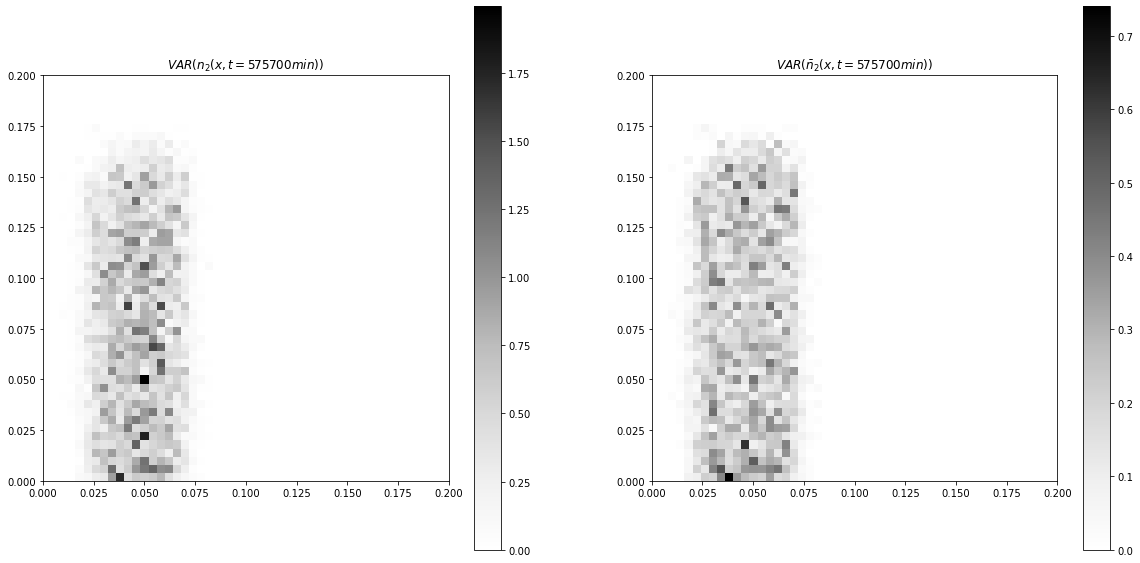

In [64]:
i = 1919
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
im1 = axs[0].imshow(np.transpose(n2v[i,:,:]), cmap='Greys', interpolation='nearest', extent=[0, ly * spatial_delta, 0, lx * spatial_delta])
axs[0].title.set_text(r'$VAR(n_2(x, t=' + str(int(i) * dt) + ' min)$)')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(np.transpose(n2v_control[i, :, :]), cmap='Greys', interpolation='nearest', extent=[0, ly * spatial_delta, 0, lx * spatial_delta])
axs[1].title.set_text(r'$VAR(\bar{n}_2(x, t=' + str(int(i) * dt ) + ' min)$)')
fig.colorbar(im2, ax=axs[1])
plt.savefig(SAVEPATH +'variances.png')
plt.show()

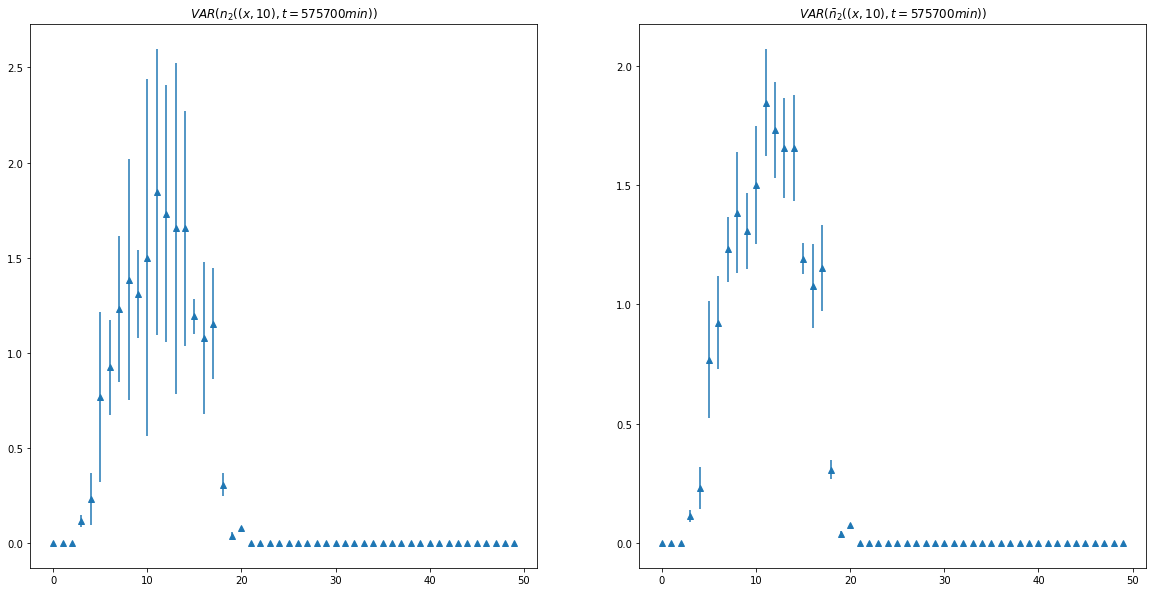

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].errorbar(np.arange(50), n2[i-1,:,40], n2v[i-1,:,30], linestyle='None', marker='^')
axs[0].title.set_text(r'$VAR(n_2((x,10), t=' + str(int(i * dt)) + ' min)$)')
axs[1].errorbar(np.arange(50), n2[i-1,:,40], n2v_control[i-1,:,30], linestyle='None', marker='^')
axs[1].title.set_text(r'$VAR(\bar{n}_2((x,10), t=' + str(int(i * dt)) + ' min)$)')
plt.savefig(SAVEPATH +'errors.png')
plt.show()